# Tentative de transfert de couleur sur la base de données de 2000 images jour/nuit



---


En se basant sur une version modifiée pour l'occasion du dataset et du colornet d'oumaima, on se propose ici de tenter d'entrainer un réseau de neurones type colornet aux transitions jour/nuit



---

Pistes d'amélioration :
- Ajouter un booléen pour passer nuit/jour vs jour/nuit

In [3]:
# System/Filesystem
import sys
import os
import glob

# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# images
from skimage import color
import cv2


### ColorNet

Le réseau ColorNet employé ici est légèrement différent de celui donné sur le notebook de colorisation. On modifie ses entrées et sorties pour accepter du R,G,B et sortir du R,G,B plutôt que d'avoir une matrice d'intensité en entrée.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x


### Le Dataset

Par rapport aux autres versions du code, celui-ci est capable de différencier les villes d'entrainement et les villes de test. Les villes 1 à 6 servent à s'entrainer, les 7 et 10HD servent à tester la capacité de généralisation du réseau.


In [11]:
class CustomDataset(Dataset):
    def __init__(self, train: bool = True):
        self.imgs_path = "drive/MyDrive/DB_2048_jpg/"
        file_format = ".jpg"

        file_list = glob.glob(self.imgs_path + "*")
        
        training_towns = ["town01","town02","town03","town04","town05","town06"]
        test_towns     = ["town07","town10HD"]

        if train:
            towns = training_towns
            type="train"
        else:
            towns = test_towns
            type="test"

        self.data = []
        class_path_1 = file_list[-1]
        class_path_2 = file_list[-2]
        class_name_1 = class_path_1.split("/")[-1]
        class_name_2 = class_path_2.split("/")[-1]
        pathlen = class_path_1.find(class_name_1)
        print(pathlen)
        path = class_path_1[0:pathlen]
        for img_path1 in glob.glob(class_path_1+ "/rgb/*{}".format(file_format)):

            img_name = img_path1.split("/")[-1]


            new_img_day = path+class_name_1+"/rgb/"+img_name
            new_img_night = path+class_name_2+"/rgb/"+img_name

            # l'image de jour existe forcément, mais on vérifie si celle
            # de nuit associée existe
            if not os.path.exists(new_img_night):
                # image inexistante, on skip
                print("Skipping inexistent night image: {}".format(new_img_night))
            else:

                # image existante, on l'ajoute
                self.data.append([new_img_day, class_name_1, new_img_night, class_name_2])
        self.data = tuple(self.data)
        self.class_map = {"NIGHT" : 1, "DAY": 0}
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img_path1, class_name1, img_path2, class_name2 = self.data[idx]

        # loads images as (B,G,R)
        img1 = cv2.imread(img_path1)
        img2 = cv2.imread(img_path2)

        # swap as (R,G,B)
        img1[:,:,[0,2]] = img1[:,:,[2,0]]
        img2[:,:,[0,2]] = img2[:,:,[2,0]]

        class_id1 = self.class_map[class_name1]
        class_id2 = self.class_map[class_name2]
        img_tensor1 = torch.tensor(img1)/255
        img_tensor2 = torch.tensor(img2)/255

        img_tensor1 = torch.transpose(img_tensor1,0,2)
        img_tensor2 = torch.transpose(img_tensor2,0,2)

        f = transforms.Resize([192,108])

        img_tensor1 = f(img_tensor1)
        img_tensor2 = f(img_tensor2)


        return (img_tensor1, img_tensor2)


Maintenant, on règle quelques variables

In [32]:
cnet=ColorNet()

# variables
batch_size = 32
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)
n_epoch = 100

# starting
train_dataset = CustomDataset()
test_dataset  = CustomDataset(False)

train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
bup_cnet = ColorNet()
cnet = cnet.to(device)
bup_cnet = bup_cnet.to(device)

# imshow
def imshow(tensor, title=None, transpose=True):
    """
    converts a tensor into a PIL image and displays it
    Tensor has to be shaped [1,c,h,w] or [c,h,w]
    """

    # reducing dimension  
    if len(tensor.shape)==4:
        tensor = tensor[0,:,:,:]
    if tensor.requires_grad:
        tensor = tensor.detach()
    img = tensor.numpy()
    print("Shape: {}".format(img.shape))
    if transpose:
        img = np.transpose(img,(2,1,0))

    plt.figure()
    plt.imshow(img)
    if not title is None:
        plt.title(title)





26
26


### Boucle d'apprentissage

Sur une seule image, 5000 epoch ont suffit à avoir un résultat satisfaisant.

Ici, on tourne sur une plus grosse base de données (1500 images d'apprentissage, 500 de test). On va commencer par 100 epoch, puis on modifiera au besoin.

In [18]:
def epoch(model = cnet, loader = train_loader, optimizer = optimizer, device = device, train=True):
  """
  function to do an epoch of a given dataset
  ---------------------
  Args:
    model     --> network to use
    loader    --> dataloader object to use
    optimizer --> optimizer used for training
    device    --> device to use ('cpu' or 'cuda:0')
    train     --> flag to tell if the model can be trained on this epoch
  ----------------------
  Return:
    loss.item() --> Quantity of loss, as an int
  """
  t = transforms.Resize([192,108])
  total_loss = 0
  for i, (day, night) in enumerate(loader):
    day = day.to(device)
    night = night.to(device)
    guesses = t(cnet(day))
    if guesses.shape != night.shape:
      print("{} vs {} at iteration {}".format(guesses.shape,night.shape, i))
    loss = F.mse_loss(guesses,night)
    if train:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    total_loss += loss.item()
  return total_loss

In [14]:
cnet_path = "drive/MyDrive/cnet/"

if not os.path.exists(cnet_path):
  os.mkdir(cnet_path)



def save_cnet(iter: int, path: str = cnet_path, cnet=cnet):
  """
  saves the weights of the neural network
  """
  iter_filename = path+"iter"
  cnet_filename = path+"cnet.pt"

  

  # saving the weights
  torch.save(cnet.state_dict(), cnet_filename)

  # saving the iterations
  f = open(iter_filename,"w+")
  f.write(str(iter))
  f.close()
  


def load_cnet(path: str = cnet_path) -> int:
  """
  loads the last saved neural network
  """
  iter_filename = path+"iter"
  cnet_filename = path+"cnet.pt"

  if not os.path.exists(iter_filename):
    return 0

  # load the weights
  cnet.load_state_dict(torch.load(cnet_filename))

  f = open(iter_filename, "r")
  line = f.readline()
  f.close()
  return int(line)

In [ ]:
min_loss = float('inf')
train_losses = []
test_losses  = []
iter = load_cnet()
for i in range(iter, n_epoch):
  
  print("Epoch {}/{} ({}% done)".format(i,n_epoch,(i/n_epoch)*100))
  cnet.train()
  train_losses.append(epoch()) # training epoch
  cnet.eval()
  loss = epoch(loader=test_loader, train=False)
  if loss < min_loss:
    print("Backup created.")
    bup_cnet.load_state_dict(cnet.state_dict())
    save_cnet(i) # saves the cnn as a file, as well as the number of iteration
  test_losses.append(loss)

Epoch 4/100 (4.0% done)


### On vérifie désormais si le réseau a bien fonctionné

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: (3, 192, 108)
Shape: (3, 192, 104)
Shape: (3, 192, 108)


'\nguess = cnet(day[0])\n\nimshow(night[0], title="Image de nuit")\nimshow(guess, title="Image générée")\n'

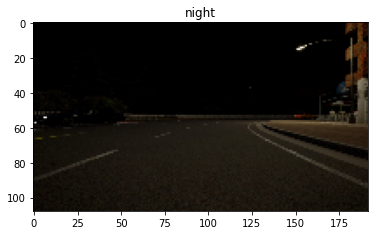

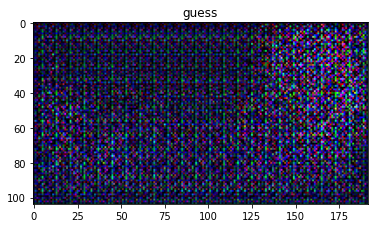

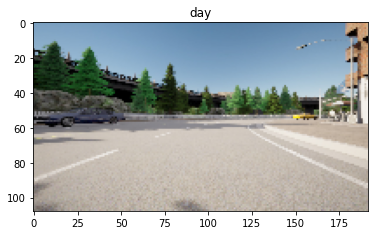

In [37]:
t = enumerate(test_loader)
for i, (img_day, img_night) in t:
  imshow(img_day, title="night")
  guess = cnet(img_day.to(device))
  imshow(guess.cpu(), title="guess")
  imshow(img_night, title="day")
  break
"""
guess = cnet(day[0])

imshow(night[0], title="Image de nuit")
imshow(guess, title="Image générée")
"""

In [ ]:
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

ValueError: ignored